In [8]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

np.random.seed(0)

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

import warnings
warnings.filterwarnings('ignore')

# Data

**Attribute**                    Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class: (2 for benign, 4 for malignant)
  
  ## Read Data

In [2]:
# UCI URL to breast cancer data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'

cols = ["id_number", "Clump Thickness", 
        "Uniformity of Cell Size", "Uniformity of Cell Shape", 
        "Marginal Adhesion", "Single Epithelial Cell Size", 
        "Bare Nuclei", "Bland Chromatin", 
        "Normal Nucleoli", "Mitoses", "Class"]

data = pd.read_csv('./breast-cancer-wisconsin.csv', header=None, na_values=['?'])
data.columns = cols

# the only missing data is found in the Bare Nuclei (designated by a ?)
# there are 16 such records...for now lets drop them
data = data.dropna(axis=0, how="any")
data.Class = data.Class.map({2:0, 4:1})

# below we assign a weight to the class percent in the entire dataset
#data["weight"] = data.Class.map({0:0.650073, 1:0.349927})
# the actual probability of developing breast cancer is around 12%
#data["weight2"] = data.Class.map({0:0.88, 1:0.12})
data.drop('id_number', axis=1, inplace=True)

# remove Class outcome from data and place in separate data frame
#y = data.Class.to_frame()
#data.drop('Class', axis=1, inplace=True)

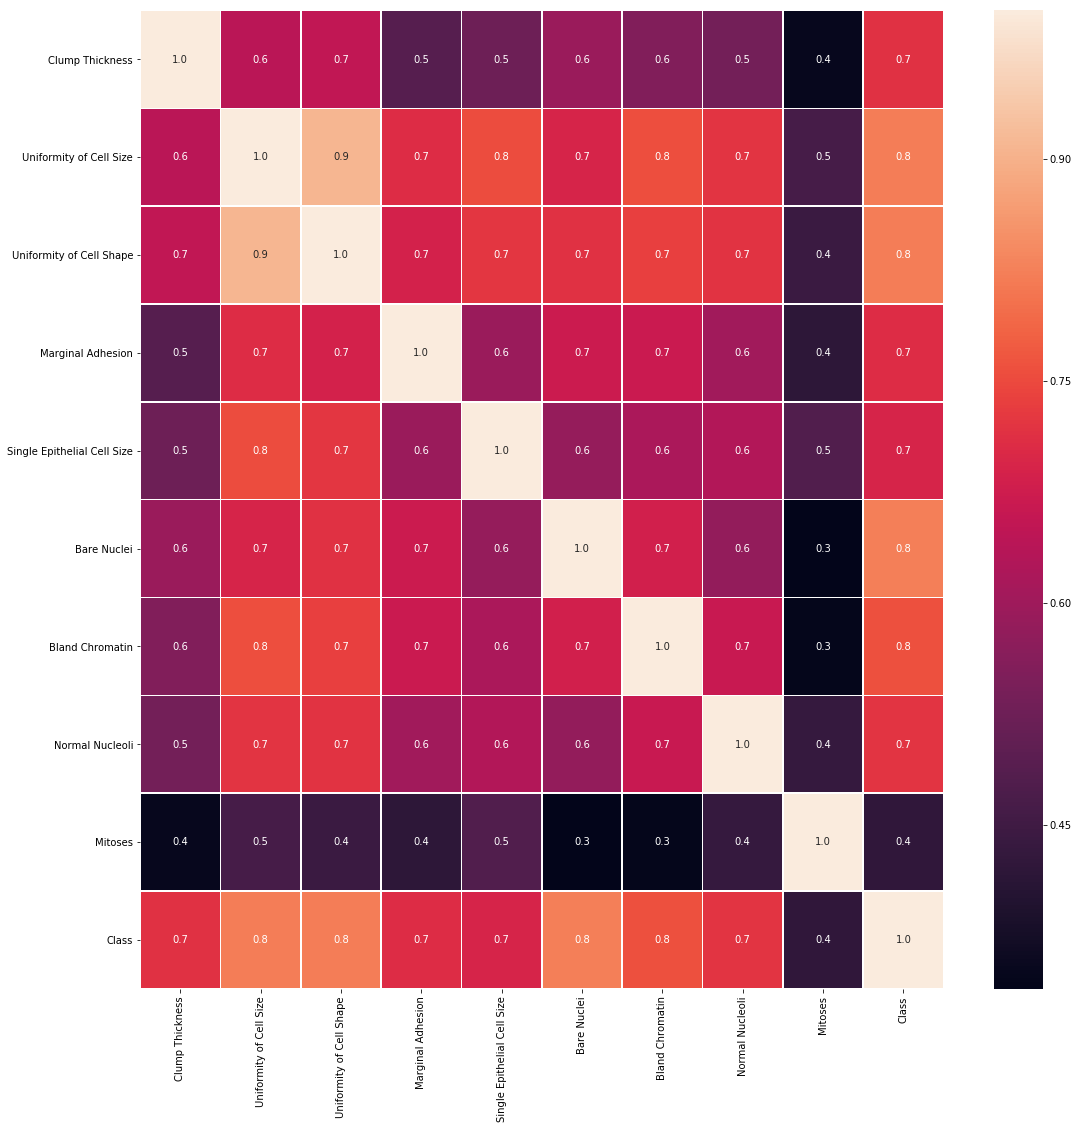

In [4]:
# Correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

## Split

In [3]:
df_train, df_test = train_test_split(data, test_size = 0.3)
x_train=df_train.drop('Class',axis=1)
x_test=df_test.drop('Class',axis=1)
y_train=df_train['Class']
y_test=df_test['Class']

## Transformations

### PCA

In [5]:
# scale data
data_scaled = preprocessing.scale(data.values)

# Call PCA method
# let's call n_components = 2
pca = PCA(n_components=9)
pca_ = pca.fit_transform(data_scaled)
pca_components = pd.DataFrame(pca_)
pca_components.columns = data.columns[:9]

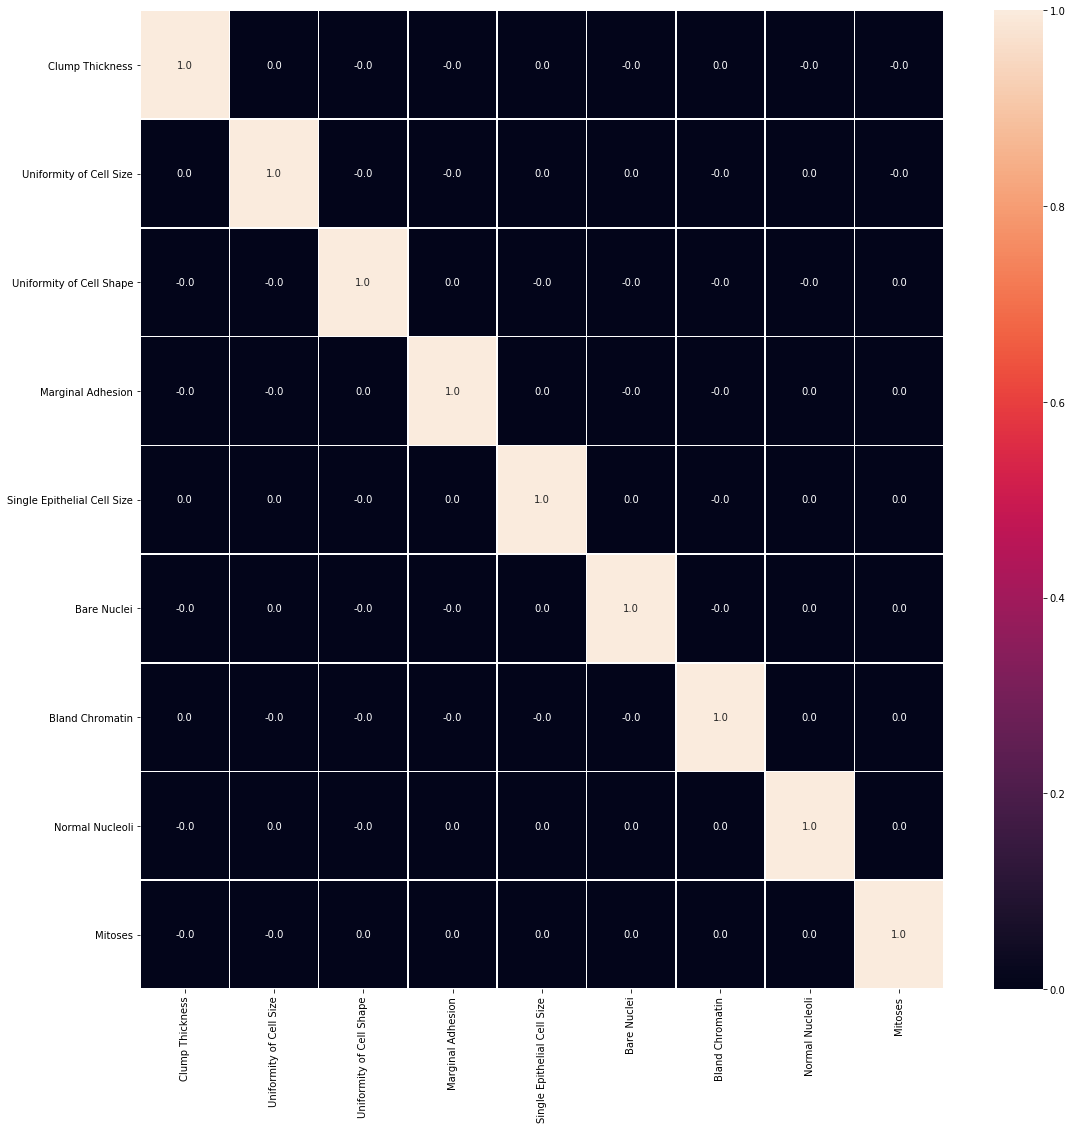

In [7]:
# Correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pca_components.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

In [6]:
# need to attach y
pca_components["Class"] = data["Class"]
pca_train, pca_test = train_test_split(pca_components, test_size = 0.3)
x_pca_train=pca_train.drop('Class',axis=1)
x_pca_test=pca_test.drop('Class',axis=1)
y_pca_train=pca_train['Class']
y_pca_test=pca_test['Class']

#### Takeaway  
After PCA transforming the input features, I got pretty bad results:
  1. Logistic Regression: 0 false negatives, 78 false positives
  2. Decision Tree: 1 false negative, 78 false positives
  3. Random Forest: 17 false negatives, 69 false positives
  
As this is a medical test for a relatively rare condition (breast cancer affects about 12% of the population), we need to ensure we minimize false negatives/positives so PCA is not a good idea.

# Models

## Logistic Regression

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       130
           1       0.94      0.88      0.91        75

   micro avg       0.94      0.94      0.94       205
   macro avg       0.94      0.92      0.93       205
weighted avg       0.94      0.94      0.94       205

[1.         0.95238095 0.95238095 0.95238095 0.85714286 0.95
 0.9        0.9        1.         0.95      ]
Average CV: 0.9414
CV variance: 0.0018


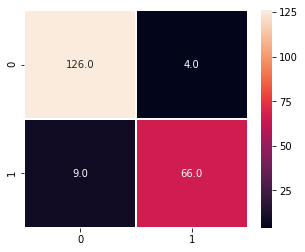

In [7]:
#Create the model
model_lr = LogisticRegression()
model_lr.fit(X=x_train,y=y_train)

#Prediction
predicion_lr = model_lr.predict(x_test)
#Results:

#Clasification report
results_lr=metrics.classification_report(y_true=y_test, y_pred=predicion_lr)
print(results_lr)

#Confusion matrix
cm_rl=metrics.confusion_matrix(y_true=y_test, y_pred=predicion_lr)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_rl, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

cv_lr = cross_val_score(model_lr, x_test, y_test, cv=10)
print(cv_lr)
print("Average CV: {:.4f}".format(cv_lr.mean()))
print("CV variance: {:.4f}".format(cv_lr.var()))

## Decision Tree

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       130
           1       0.93      0.89      0.91        75

   micro avg       0.94      0.94      0.94       205
   macro avg       0.94      0.93      0.93       205
weighted avg       0.94      0.94      0.94       205

[0.95238095 1.         0.9047619  1.         0.80952381 1.
 0.95       0.9        0.95       1.        ]
Average CV: 0.9467


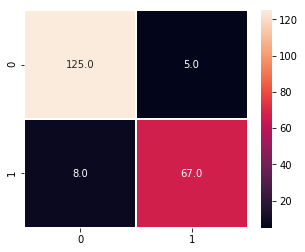

In [10]:
# Create the model
model_dt = DecisionTreeClassifier(criterion="gini", max_features=8, max_depth=4)
# Fit the model
model_dt.fit(X=x_train,y=y_train)

# Prediction
predicion_dt = model_dt.predict(x_test)

#Results:

#Clasification report
results_dt = metrics.classification_report(y_true=y_test, y_pred=predicion_dt)
print(results_dt)

#Confusion Matrix
cm_dt = metrics.confusion_matrix(y_true=y_test, y_pred=predicion_dt)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_dt, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

cv_dt = cross_val_score(model_dt, x_test, y_test, cv=10)
print(cv_dt)
print("Average CV: {:.4f}".format(cv_dt.mean()))

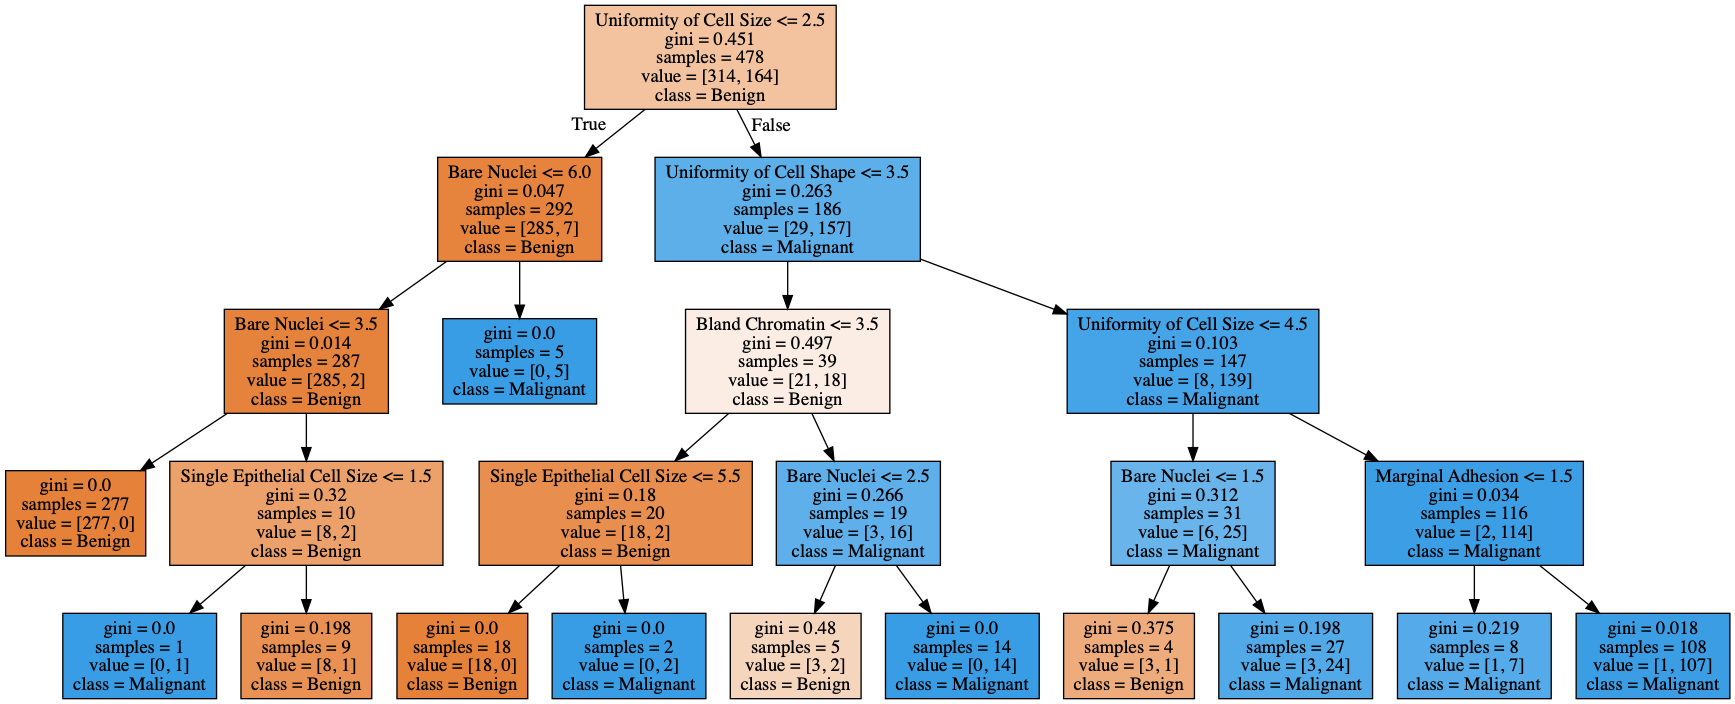

In [11]:
# Render our tree.
dot_data_dt = tree.export_graphviz(
    model_dt, out_file=None,
    feature_names=x_train.columns,
    class_names=['Benign', 'Malignant'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data_dt)
Image(graph.create_png())

This model places the majority of importance on the Uniformity of Cell Shape feature (77%), followed by Bare Nuclei (~11%).

*Now that we have eliminated the collinearity among input features so we are ready to build some models!*

Here is the class breakdown; there is an imbalance among the 2 classes, and I suspect this disparity is much more imbalanced in the real world (like < 1%). How you sample is very important here. 

## Random Forest

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       130
           1       0.96      0.85      0.90        75

   micro avg       0.93      0.93      0.93       205
   macro avg       0.94      0.92      0.92       205
weighted avg       0.93      0.93      0.93       205

[1.         0.95238095 0.95238095 0.95238095 0.85714286 0.95
 0.9        0.9        0.9        1.        ]
Average CV: 0.9364


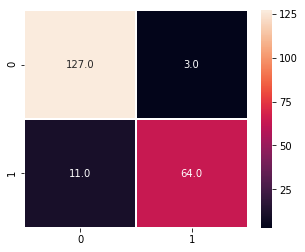

In [12]:
model_rf = RandomForestClassifier(max_features=8, random_state=0, n_estimators=10)
model_rf.fit(x_train,y_train)

predicion_rf = model_rf.predict(x_test)
#Clasification report
results_rf = metrics.classification_report(y_true=y_test, y_pred=predicion_rf)
print(results_rf)

#Confusion Matrix
cm_rf = metrics.confusion_matrix(y_true=y_test, y_pred=predicion_rf)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

cv_rf = cross_val_score(model_rf, x_test, y_test, cv=10)
print(cv_rf)
print("Average CV: {:.4f}".format(cv_rf.mean()))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       130
           1       0.93      0.88      0.90        75

   micro avg       0.93      0.93      0.93       205
   macro avg       0.93      0.92      0.93       205
weighted avg       0.93      0.93      0.93       205

[1.         1.         0.95238095 1.         0.9047619  0.95
 0.95       0.9        0.95       1.        ]
Average CV: 0.9607


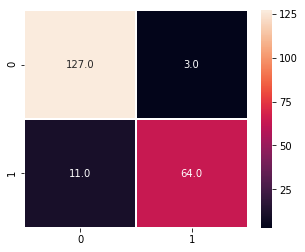

In [13]:
model_rf2 = RandomForestClassifier(max_features=8,random_state=0, n_estimators=1000)
model_rf2.fit(x_train,y_train)

predicion_rf2 = model_rf2.predict(x_test)
results_rf2 = metrics.classification_report(y_true=y_test, y_pred=predicion_rf2)
print(results_rf2)

#Confusion Matrix
cm_rf2 = metrics.confusion_matrix(y_true=y_test, y_pred=predicion_rf2)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

cv_rf2 = cross_val_score(model_rf2, x_test, y_test, cv=10)
print(cv_rf2)
print("Average CV: {:.4f}".format(cv_rf2.mean()))

# Conclusion

So a 100 fold increase in the number of trees results in an increase in the CV mean from 0.9364 to 0.9607. However, as mentioned previously this is a sensitive medical test so we need to minimize the number of false negatives and false positives, and this model actually increases these numbers (over the first random forest model).  

Of the 3 types of models built and evaluated, the logistic regression model performs tbe best.  